# Attention Walmart Customers

## Capstone Presentation
Cindy Villanueva | Alberto Puentes | Heather McMillan | Natasha Rivers

#### August 19, 2021

<hr style="border:3px solid black"> </hr>

# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import new_wrangle as w
import model as m

#sklearn preprossing, clustering and modeling libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_score

#remove warnings
import warnings
warnings.filterwarnings("ignore")

## Color Palette Specs for Visualization

In [2]:
#color palette for visualizations
walmart_palette_c = ['#004c91', '#007dc6', '#78b9e7', '#f47321', '#ffc220', '#367c2b', '#76c043']
walmart_palette_d = ['#004c91', '#ffc220' , '#f47321', '#367c2b','#007dc6', '#76c043', '#78b9e7']
sns.color_palette(walmart_palette_c)
sns.set_palette(walmart_palette_d)
sns.color_palette(walmart_palette_d)

[(0.0, 0.2980392156862745, 0.5686274509803921),
 (1.0, 0.7607843137254902, 0.12549019607843137),
 (0.9568627450980393, 0.45098039215686275, 0.12941176470588237),
 (0.21176470588235294, 0.48627450980392156, 0.16862745098039217),
 (0.0, 0.49019607843137253, 0.7764705882352941),
 (0.4627450980392157, 0.7529411764705882, 0.2627450980392157),
 (0.47058823529411764, 0.7254901960784313, 0.9058823529411765)]

<hr style="border:3px solid black"> </hr>

# Acquire

<hr style="border:2px solid blue"> </hr>

In [3]:
# Import data
df= w.acquire_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


**Key Findings and Takeaways**:
* Data sets provided in two .csv files that are merged into one dataframe for the project


<hr style="border:3px solid black"> </hr>

# Prepare

<hr style="border:2px solid blue"> </hr>

In [5]:
# Execute preparation function
data= w.wrangle_walmart()

**Key Findings and Takeaways**:
* basic clean consisted of lowercasing features, renaming columns, converting selected dtypes appropriately, rounding decimals and converting date object into datetime 
* identified a handful of outliers based on store type and weekly sales data and decided to reclassify store type in accordance with prevailing weekly sales threshold
* feature engineering:
    * added feature labeling holiday by Date: Super Bowl, Labor Day, Thanksgiving and Christmas
        * additional column created with dummy variables for the holidays
        * pre_christmas feature was created to capture the Christmas holiday sales buildup two weeks prior
    * created additional feature containing the following week's 52 week (1yr) weekly sales lookback by shifting up weekly sales by 51 periods
    * created monthly and quarterly rolling window features in each observation for this_week_unemployment, fuel_prices & CPI features
        * Additionally, created delta features for all above on a month-over-month and quarter-over-quarter basis
            * each observation had the rolling window averages...look backs of 4 and 12 periods with percent change calculation
    * created new index concating (current Date) + (store number) + (week+1 Date) features
    * **Target**: weekly sales shifted back 1 time period to be regressed on observation features from previous week

### Data Split

In [6]:
#split data using split_scale function in new_wrangle.py
train, test,  X_train_scaled, X_test_scaled, y_train, y_test = w.split_scale(data, 'next_week_sales_target', scaler = MinMaxScaler())

train -> (2866, 32)
test -> (1229, 32)


<hr style="border:3px solid black"> </hr>

# Explore

<hr style="border:2px solid blue"> </hr>

### Bivariate Exploration

Text(0.5, 1.0, 'Store Type by Size')

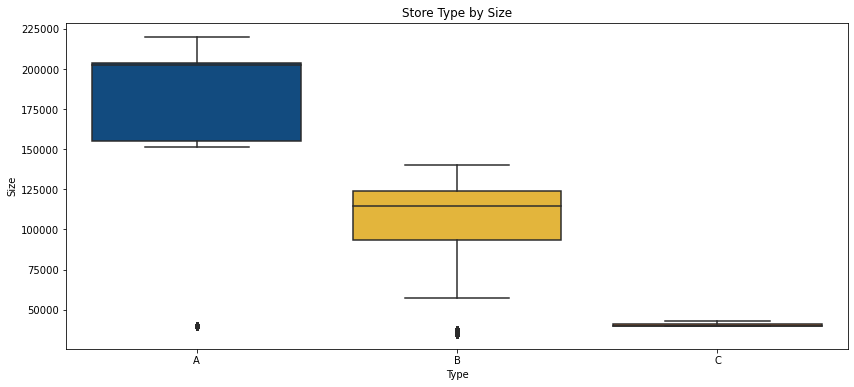

In [7]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='Type', y='Size', data=df)
plt.title('Store Type by Size')

***
**Key Findings and Takeaways**:
* Store type directly related to size
    * anomalous observations in store types A & B appear more in line with store type C
        * these were: store 3, store 5, store 33, store 36 
        * instead of dropping, we decided to reclassify these and include them in our type C data
***

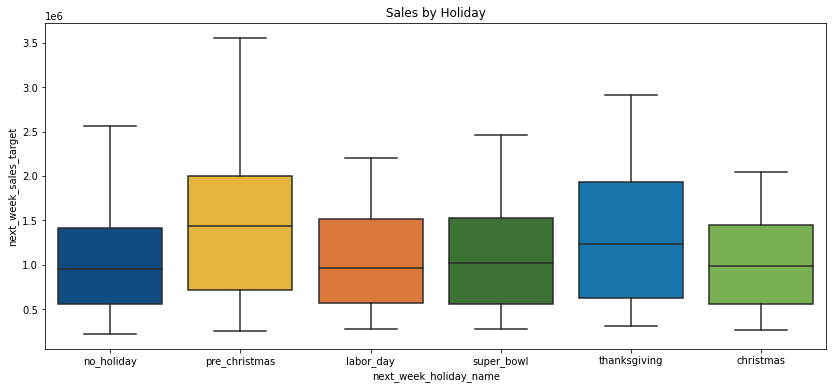

In [8]:
#visualize target with holidays
plt.figure(figsize=(14,6))
sns.boxplot(x= train['next_week_holiday_name'], y =train['next_week_sales_target'] )
plt.title('Sales by Holiday')
plt.show()

***
**Key Findings and Takeaways**:
* Our Pre_Christmas & Thanksgiving sales appear to be strong sales drivers.  
    * further investigation shows Thanksgiving sales are primarily driven by Black Friday specials
    * after noticing a run up in sales leading into the Christmas week, we created an additional feature to capture this period
        * the exploration above shows our pre_Christmas period being our strongest sales driver within these observations
            * the Christmas tag was applied to the week ending after the Christmas holiday negating the holiday impact; unlike the Thanksgiving holiday where Black Friday occurs in the same week
***

## Hypothesis Testing

### Hypothesis 1: Pearson's (cont vs cont)
$H_0$: There is no correlation between this week sales and next week sales

$H_a$: There is a correlation between this week sales and next week sales

In [9]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

#calculate alpha
alpha = 1- conf_in

#identify x and y
x= train.next_week_sales_target
y= train.this_week_sales

In [10]:
#calculate r and p values
r, p = stats.pearsonr(x,y)
r,p

(0.9627654091073867, 0.0)

In [11]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.962765 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Hypothesis 2: Pearson's (cont vs cont)
$H_0$: There is no correlation between this week sales and sales from the same period last year

$H_a$: There is a correlation between this week sales and sales from the same period last year

In [12]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

#calculate alpha
alpha = 1- conf_in

In [13]:
#identify x and y
x= train.next_week_sales_target
y= train.next_week_1_year_ago

In [14]:
#calculate r and p values
r, p = stats.pearsonr(x,y)
r,p

(0.986894918144877, 0.0)

In [15]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.986895 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


## Hypothesis 3: T-Test (discrete vs cont)
$H_0$: There is no relationship between this next_weeks_sales_target and pre_christmas

$H_a$: There is a relationship between this next_weeks_sales_target and pre_christmas

In [16]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

#calculate alpha
alpha = 1- conf_in

In [17]:
#identify x and y
x= train.next_week_sales_target
y= train.next_week_1_year_ago

In [18]:
#calculate r and p values
r, p = stats.pearsonr(x,y)
r,p

(0.986894918144877, 0.0)

In [19]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.986895 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


***
#### Key Findings and Takeaways:
* These were all must haves.  
    * If weekly sales observations were independent, there would be no common drivers to explore and build a regression model around that would enable us to forecast weekly sales one week in advance.  
    * Additionally, establishing statistical significance in the relationship between our target and our pre_christmas feature enables us to model what our exploration clearly defined as our most significant source of seasonality
    
Given that the p values were all below 0.05, we have a project!
***

## Addressing Collinearity in our Engineered Features

### - Testing for collinearity: engineered unemployment features

In [20]:
w.collinearity_unemployment(X_train_scaled)

avgMoM_perc_unemp
corr = 0.118731537407999 p = 1.8166717802245066e-10
--------------------
avgQoQ_perc_unemp
corr = 0.24335643411080382 p = 6.579108173564812e-40
--------------------
unemp_quarterly_rolling
corr = 0.9977360709700848 p = 0.0
--------------------
unemp_4wk_rolling
corr = 0.9992227600633458 p = 0.0
--------------------
avgMoM_perc_unemp
corr = 0.10604337958130702 p = 1.2658573351628604e-08
--------------------
avgQoQ_perc_unemp
corr = 0.23373773886647334 p = 7.27299461041251e-37
--------------------
unemp_quarterly_rolling
corr = 0.9989372056608832 p = 0.0
--------------------
unemp_4wk_rolling
corr = 1.0 p = 0.0
--------------------
avgMoM_perc_unemp  v avgQoQ_perc_unemp
corr = 0.42015665946780817 p = 5.697728673158536e-123


***
Findings & Takeaways: unemployment
* this_week_unemployment nearly perfectly correlated with rolling avgs; p value under 0.05, recommend dropping unemployment
* rolling averages nearly perfectly correlated with each other; p value under 0.05, recommend dropping quarterlyrolling
* deltas correlation co-efficient 0.42. p value under 0.05; is this correlation significant enough to drop?
***

### - Testing for collinearity: engineered fuel price features

In [21]:
w.collinearity_fuel(X_train_scaled)

avgMoM_perc_unemp
corr = 0.22536028121337215 p = 2.525626019017981e-34
--------------------
avgQoQ_perc_unemp
corr = 0.09390810320313361 p = 4.7458432357661235e-07
--------------------
unemp_quarterly_rolling
corr = 0.1859750448700766 p = 1.021484686969993e-23
--------------------
unemp_4wk_rolling
corr = 0.19629356000602738 p = 2.754434456647276e-26
--------------------
avgMoM_perc_unemp
corr = 0.24675601282714016 p = 5.126169336456035e-41
--------------------
avgQoQ_perc_unemp
corr = 0.12314590521290153 p = 3.717131694914673e-11
--------------------
unemp_quarterly_rolling
corr = 0.18199811813415423 p = 9.129155218579996e-23
--------------------
unemp_4wk_rolling
corr = 0.19396902200088353 p = 1.0755548996774414e-25
--------------------
avgMoM_perc_fuel  v avgQoQ_perc_fuel
corr = 0.20665753628119032 p = 5.139079719981134e-29


***
Findings & Takeaways: fuel price
* fuel_price nearly perfectly correlated with rolling avgs; p value under 0.05, recommend dropping fuel_price
* 4wk rolling has a 0.37 corr coefficient vs avgQoQ; p value under 0.05, is this threshold high enough to drop?
* rolling averages strongly correlated with each other; p value under 0.05, recommend dropping quarterly rolling as 4wk captures both quarterly rolling and fuel price well
* deltas correlation co-efficient 0.2; p value under 0.05, recommend keeping both
***

### - Testing for collinearity: engineered CPI features

In [22]:
w.collinearity_cpi(X_train_scaled)

avgMoM_perc_unemp
corr = -0.014211003748105383 p = 0.4469598898290615
--------------------
avgQoQ_perc_unemp
corr = 0.03108345138763549 p = 0.09616645069288744
--------------------
unemp_quarterly_rolling
corr = -0.2601365588901102 p = 1.510831519248753e-45
--------------------
unemp_4wk_rolling
corr = -0.2596021152202652 p = 2.319314607556736e-45
--------------------
avgMoM_perc_unemp
corr = -0.014211003748105383 p = 0.4469598898290615
--------------------
avgQoQ_perc_unemp
corr = 0.03108345138763549 p = 0.09616645069288744
--------------------
unemp_quarterly_rolling
corr = -0.2601365588901102 p = 1.510831519248753e-45
--------------------
unemp_4wk_rolling
corr = -0.2596021152202652 p = 2.319314607556736e-45
--------------------
avgMoM_perc_cpi  v avgQoQ_perc_cpi
corr = 0.16972298678073489 p = 5.767077223928e-20


***
#### Findings & Takeaways: CPI
* CPI nearly perfectly correlated with rolling avgs; p value under 0.05, recommend dropping CPI
* rolling averages nearly perfectly correlated with each other; p value under 0.05, recommend dropping quarterly rolling
* deltas correlation co-efficient 0.25. p value under 0.05; is this correlation significant enough to drop?
***

*** Iterative Feature Elimination due to Auto Correlation findings ***

In [23]:
#features to drop before modeling due to autocorrelation
col = ['this_week_unemployment', 'fuel_price', 'CPI', 'unemp_quarterly_rolling', 'fuel_quarterly_rolling', 'cpi_quarterly_rolling']

#drop columns that have coliniarity
X_train_scaled = X_train_scaled.drop(columns = col)
X_test_scaled = X_test_scaled.drop(columns = col)

<hr style="border:3px solid black"> </hr>

# Modeling

<hr style="border:2px solid blue"> </hr>

***
**Summary Notes for modeling section**:
    
* **Scaler utilized** = MinMax()

* **Baselines**: 1) weekly sales mean & 2) 52 week look back to previous year weekly sales ('next_week_1_year_ago')

* **Algorithms utilized:**
    - Linear Regression(OLS)
    - Lasso Lars
    - TweedieRegressor (GLM)
    - Polynomial Regression

For each model we used :

 - **GridSearchCV**: grid search cross-validation (GridSearchCV) for hyperparameter optimization.
 
- **Feature Engineering:**

   - **RFE :** (recursive feature elimination)  recursively removes attributes to meet the required number of features and then builds a model on those attributes that remain.
   - **Select KBest:** removes all but the highest scoring features.
***

### Features

In [24]:
# set model features
features = ['store_size', 'this_week_unemployment', 'next_week_1_year_ago', 'this_week_sales', 'pre_christmas']

### Y_train and Y_test

In [25]:
# convert y_train y _ validate to df
y_train_df = pd.DataFrame( {'actual': y_train})
y_test_df = pd.DataFrame( {'actual': y_test})

### Baseline 1 - (weekly sales mean)

In [26]:
# create the baseline using mean of actual weekly sales
baseline= y_train_df['actual'].mean()

In [27]:
# create column called baseline to compare
y_train_df['baseline'] = baseline

In [28]:
# calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train_df.actual, y_train_df.baseline))

In [29]:
# create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': "Baseline (using mean)",
    'rmse_train': round(rmse_baseline_train, 4),
    'r^2': round(explained_variance_score(y_train_df.actual, y_train_df.baseline), 4)

}])

round(metric_df, 4)

,model,rmse_train,r^2
0,Baseline (using mean),558467.0491,0.0


### Baseline 2 - (prior year's weekly sales)

In [30]:
# baseline using last years sales as predictions
y_train_df['last_year_baseline'] = train['next_week_1_year_ago']

In [31]:
# calculate RMSE for baseline 2 model
rmse_baseline2_train= math.sqrt(mean_squared_error(y_train_df.actual, y_train_df.last_year_baseline))

In [32]:
# RMSE Baseline 2
round(rmse_baseline2_train, 4)

91145.2822

In [33]:
# add Baseline 2 to our metric_df
metric_df = metric_df.append(
    {
    'model': "Baseline (using last year's sales)",
    'rmse_train': round(rmse_baseline2_train, 2),
    'r^2': round(explained_variance_score(y_train_df.actual, y_train_df.last_year_baseline),4),
    }, ignore_index=True)

round((metric_df), 4)

,model,rmse_train,r^2
0,Baseline (using mean),558467.0491,0.0000
1,Baseline (using last year's sales),91145.2800,0.9738


## MODEL 1: LinearRegression (OLS)

### - Hyperparameter optimization with Gridsearch

In [34]:
# specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {'normalize': [ True, False],
          'fit_intercept': [True, False]}

In [35]:
# deploy gridsearch function using 
round(m.gridsearch(X_train_scaled, y_train_df, LinearRegression() , params, 'neg_root_mean_squared_error'), 4)

,fit_intercept,normalize,score
2,False,True,-70244.1431
3,False,False,-70244.1431
1,True,False,-23555.0764
0,True,True,-23555.0764


### - Feature Selection using Select K Best

In [36]:
y_train_df.columns

Index(['actual', 'baseline', 'last_year_baseline'], dtype='object')

In [37]:
# using my function for SelectkBest
top_sb = m.select_kbest(X_train_scaled, y_train, 10)

The top 10 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']


In [38]:
# create the model and calculate RMSE
ols_sb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual',\
                       LinearRegression(normalize=False,\
                        fit_intercept=True ), 'modelOLS' )
round(ols_sb['rmse'], 4)

72474.379

### cross validation

In [39]:
# create the model
clf = LinearRegression(normalize=True, fit_intercept=True )
# cv = number of folds
cross_val_score(clf, X_train_scaled[top_sb], y_train, cv=3, scoring = 'neg_root_mean_squared_error')

array([-72769.62947968, -73703.84102292, -73404.54496025])

In [40]:
# add the ols_sb model metrics to metric_df
metric_df = metric_df.append(
    {
    'model': 'ols_sb',
    'rmse_train': ols_sb['rmse'],    
    'r^2' : ols_sb['r2']}, ignore_index=True)

### - Feature Selection using  RFE

In [41]:
# use the function to get RFE selected features
top_rfe = m.select_rfe(X_train_scaled, y_train, 10,LinearRegression(normalize=True, fit_intercept=True ))

The top 10 selected feautures based on the the RFE class class are: ['this_week_sales', 'this_week_holiday_flag', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'unemp_4wk_rolling', 'avgMoM_perc_unemp', 'avgQoQ_perc_fuel', 'avgQoQ_perc_unemp']
this_week_sales            1
avgQoQ_perc_fuel           1
avgMoM_perc_unemp          1
unemp_4wk_rolling          1
thanksgiving               1
christmas                  1
avgQoQ_perc_unemp          1
next_week_1_year_ago       1
store_size                 1
this_week_holiday_flag     1
avgMoM_perc_cpi            2
labor_day                  3
super_bowl                 4
fuel_4wk_rolling           5
pre_christmas              6
avgMoM_perc_fuel           7
avgQoQ_perc_cpi            8
next_week_holiday_flag     9
temperature               10
cpi_4wk_rolling           11
dtype: int64


In [42]:
# create the model and calculate RMSE
ols_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual', LinearRegression(normalize=True, fit_intercept=True ), 'modelOLS' )
round(ols_rfe['rmse'], 4)

70339.0705

### cross validation

In [43]:
# create the model
clf = LinearRegression(normalize=True, fit_intercept=True )
# cv = number of folds
cross_val_score(clf, X_train_scaled[top_rfe], y_train, cv=3, scoring = 'neg_root_mean_squared_error')

array([-70080.50217941, -71528.662538  , -71789.27133027])

In [44]:
# add the ols_rfe model metrics to metric_df
metric_df = metric_df.append(
    {
    'model': 'ols_rfe',
    'rmse_train': ols_rfe['rmse'],    
    'r^2' : ols_rfe['r2']}, ignore_index=True)

## MODEL 2: LassoLars

### - Hyperparameter optimization with Gridsearch

In [45]:
# specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'normalize': [True, False],
          'fit_intercept':[True, False],
           'alpha': [1.0, 0]
         }

In [46]:
# use the function to get the combinations of parameters
round(m.gridsearch (X_train_scaled, y_train, LassoLars() , params, 'neg_root_mean_squared_error'), 4)

,alpha,fit_intercept,normalize,score
6,0.0,False,True,-78124.1829
7,0.0,False,False,-78124.1829
2,1.0,False,True,-78123.7660
3,1.0,False,False,-78123.7660
5,0.0,True,False,-70665.2292
4,0.0,True,True,-70665.2292
1,1.0,True,False,-70664.4245
0,1.0,True,True,-70657.4154


### - Feature Selection using Select K Best

In [47]:
# using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 9)

The top 9 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling']


In [48]:
# create the model and calculate RMSE
lasso_skb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual', LassoLars(alpha = 1, normalize= True, fit_intercept= True), 'modelLasso' )
round(lasso_skb['rmse'], 2)

73370.09

### cross validation

In [49]:
# create the model
clf = LassoLars(alpha = 1, normalize= False, fit_intercept= True)
# cv = number of folds
cross= cross_val_score(clf, X_train_scaled[top_sb], y_train, cv=3, scoring = 'neg_root_mean_squared_error')
cross

array([-74045.96153329, -74430.52250561, -74022.31451342])

In [50]:
# add the lasso_skb model metrics to metric_df
metric_df = metric_df.append(
    {
    'model': 'lasso_skb',
    'rmse_train': lasso_skb['rmse'],    
    'r^2' : lasso_skb['r2']}, ignore_index=True)

### - Feature Selection using  RFE

In [51]:
# get the top 8 features
top_rfe = m.select_rfe(X_train_scaled, y_train, 6, LassoLars(alpha = 1, normalize= True, fit_intercept= True) )

The top 6 selected feautures based on the the RFE class class are: ['this_week_sales', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'avgQoQ_perc_unemp']
this_week_sales            1
thanksgiving               1
christmas                  1
next_week_1_year_ago       1
avgQoQ_perc_unemp          1
store_size                 1
unemp_4wk_rolling          2
this_week_holiday_flag     3
avgQoQ_perc_fuel           4
avgMoM_perc_unemp          5
avgMoM_perc_cpi            6
next_week_holiday_flag     7
fuel_4wk_rolling           8
avgMoM_perc_fuel           9
pre_christmas             10
labor_day                 11
avgQoQ_perc_cpi           12
cpi_4wk_rolling           13
temperature               14
super_bowl                15
dtype: int64


In [52]:
# use the function to get the combinations of parameters
round(m.gridsearch (X_train_scaled, y_train, LassoLars() , params, 'neg_root_mean_squared_error'), 4)

,alpha,fit_intercept,normalize,score
6,0.0,False,True,-78124.1829
7,0.0,False,False,-78124.1829
2,1.0,False,True,-78123.7660
3,1.0,False,False,-78123.7660
5,0.0,True,False,-70665.2292
4,0.0,True,True,-70665.2292
1,1.0,True,False,-70664.4245
0,1.0,True,True,-70657.4154


In [53]:
# create the model and calculate RMSE
lasso_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual', LassoLars(alpha = 1, normalize= False, fit_intercept= True), 'modelLasso' )
round(lasso_rfe['rmse'], 4)

71522.6664

### cross validation

In [54]:
# create the model
clf = LassoLars(alpha = 1, normalize= False, fit_intercept= True)
# cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_rfe], y_train, cv=3, scoring = 'neg_root_mean_squared_error')
cross

array([-71447.2057401 , -72244.57440475, -72581.69415924])

In [55]:
# add the lasso_rfe model to metric_df
metric_df = metric_df.append(
    {
    'model': 'lasso_rfe',
    'rmse_train': lasso_rfe['rmse'],    
    'r^2' : lasso_rfe['r2']}, ignore_index=True)

## MODEL 3: TweedieRegressor (GLM)

### - Hyperparameter optimization with Gridsearch

In [56]:
# specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'power': [0.0, 1],
           'fit_intercept' : [True , False],
          'warm_start': [True, False], 
           'alpha': [1.0, 0.0]
         }
# use the function
round(m.gridsearch (X_train_scaled, y_train,TweedieRegressor() , params, 'neg_root_mean_squared_error'), 4)

,alpha,fit_intercept,power,warm_start,score
14,0.0,False,1.0,True,-1.383688e+06
15,0.0,False,1.0,False,-1.383688e+06
6,1.0,False,1.0,True,-1.383662e+06
7,1.0,False,1.0,False,-1.383662e+06
4,1.0,False,0.0,True,-5.291123e+05
5,1.0,False,0.0,False,-5.291123e+05
0,1.0,True,0.0,True,-4.964809e+05
1,1.0,True,0.0,False,-4.964809e+05
10,0.0,True,1.0,True,-1.441567e+05
11,0.0,True,1.0,False,-1.441567e+05


### - Feature Selection using Select K Best

In [57]:
# using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 8)

The top 8 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling']


In [58]:
# create the model and calculate RMSE
gml_skb = m.create_model(X_train_scaled[top_sb], y_train_df, 'actual',TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False), 'modelgml' )
round(gml_skb['rmse'], 4)

73370.4558

### cross validation

In [59]:
# create the model
clf = TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,warm_start= False)
# cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_sb], y_train, scoring = 'neg_root_mean_squared_error',cv=3)
cross

array([-73993.90965301, -74432.17669615, -73960.92321156])

In [60]:
# add the gml_skb model to metric_df

metric_df = metric_df.append(
    {
    'model': 'gml_skb',
    'rmse_train': gml_skb['rmse'],    
    'r^2' : gml_skb['r2']}, ignore_index=True)

### -  Feature Selection using  RFE

In [61]:
# use function to get the top 8 features
top_rfe = m.select_rfe(X_train_scaled, y_train, 7, TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False) )

The top 7 selected feautures based on the the RFE class class are: ['this_week_sales', 'store_size', 'next_week_1_year_ago', 'christmas', 'thanksgiving', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']
this_week_sales            1
unemp_4wk_rolling          1
thanksgiving               1
christmas                  1
avgQoQ_perc_unemp          1
store_size                 1
next_week_1_year_ago       1
this_week_holiday_flag     2
avgQoQ_perc_fuel           3
avgMoM_perc_unemp          4
avgMoM_perc_cpi            5
labor_day                  6
super_bowl                 7
fuel_4wk_rolling           8
pre_christmas              9
avgMoM_perc_fuel          10
avgQoQ_perc_cpi           11
next_week_holiday_flag    12
temperature               13
cpi_4wk_rolling           14
dtype: int64


In [62]:
# create the model and calculate RMSE
gml_rfe = m.create_model(X_train_scaled[top_rfe], y_train_df, 'actual',TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,\
                                                                  warm_start= False), 'modelgml' )
round(gml_rfe['rmse'], 4)

71197.3705

### cross validation

In [63]:
# create the model
clf = TweedieRegressor(alpha =0 , fit_intercept= True, power=0 ,warm_start= False)
# cv = number of folds
cross = cross_val_score(clf, X_train_scaled[top_rfe], y_train, scoring = 'neg_root_mean_squared_error', cv=3)
cross

array([-71374.06029116, -72012.42497728, -72054.63146727])

In [64]:
# add the gml_rfe model to metric_df
metric_df = metric_df.append(
    {
    'model': 'gml_rfe',
    'rmse_train': gml_rfe['rmse'],    
    'r^2' : gml_rfe['r2']}, ignore_index=True)

## MODEL 4: Polynomial Regression

### - Feature Selection using  Select K Best

In [65]:
# use function to get the top 8 features
top_sb =m.select_kbest(X_train_scaled, y_train, 10)

The top 10 selected feautures based on the SelectKBest class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'next_week_holiday_flag', 'pre_christmas', 'thanksgiving', 'cpi_4wk_rolling', 'unemp_4wk_rolling', 'avgQoQ_perc_unemp']


In [66]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2) 

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[top_sb])

# transform X_validate_scaled & X_test_scaled
X_test_degree3 = pf.transform(X_test_scaled[top_sb])

### - Hyperparameter optimization with Gridsearch

In [67]:
# specify the parameters we wish to use as a dictionary, then use that dictionary when we create the class.
params = {
          'normalize': [True, False],
          'fit_intercept':[True, False],
         }

round(m.gridsearch (X_train_degree3, y_train, LinearRegression() , params, 'neg_root_mean_squared_error'), 4)

,fit_intercept,normalize,score
1,True,False,-68537.8233
0,True,True,-67663.4959
2,False,True,-67280.1478
3,False,False,-67280.1478


In [68]:
# create the model and calculate RMSE
pol_skb = m.create_model(X_train_degree3, y_train_df, 'actual',LinearRegression( normalize=True, fit_intercept = True ), 'pol2_skb' )
round(pol_skb['rmse'], 4)

64609.2037

### cross validation

In [69]:
# create the model
clf = LinearRegression( normalize=False, fit_intercept = True )
# cv = number of folds
cross = cross_val_score(clf, X_train_degree3, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
cross

array([-66016.67167466, -67841.00338362, -70257.44391932, -67202.36159337,
       -71371.636051  ])

In [70]:
# add the pol_skb model to metric_df
metric_df = metric_df.append(
    {
    'model': 'pol_skb',
    'rmse_train': pol_skb['rmse'],    
    'r^2' : pol_skb['r2']}, ignore_index=True)

### - Feature Selection using  RFE

In [71]:
# get the top 8 features by RFE
top_rfe_pol = m.select_rfe(X_train_scaled, y_train, 11, LinearRegression(normalize=False, fit_intercept = False) )

The top 11 selected feautures based on the the RFE class class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'christmas', 'pre_christmas', 'super_bowl', 'thanksgiving', 'avgMoM_perc_cpi', 'avgMoM_perc_unemp', 'avgQoQ_perc_unemp']
this_week_sales            1
avgMoM_perc_unemp          1
avgMoM_perc_cpi            1
thanksgiving               1
pre_christmas              1
christmas                  1
super_bowl                 1
next_week_1_year_ago       1
store_size                 1
temperature                1
avgQoQ_perc_unemp          1
avgQoQ_perc_fuel           2
this_week_holiday_flag     3
avgQoQ_perc_cpi            4
unemp_4wk_rolling          5
avgMoM_perc_fuel           6
cpi_4wk_rolling            7
next_week_holiday_flag     8
labor_day                  9
fuel_4wk_rolling          10
dtype: int64


In [72]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2) 

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[top_rfe_pol])

# transform X_validate_scaled & X_test_scaled
X_test_degree2 = pf.transform(X_test_scaled[top_rfe_pol])

### - Hyperparameter optimization with Gridsearch

In [73]:
round(m.gridsearch (X_train_degree2, y_train, LinearRegression() , params, 'neg_root_mean_squared_error'), 4)

,fit_intercept,normalize,score
0,True,True,-66226.5733
1,True,False,-66187.0843
2,False,True,-66187.0843
3,False,False,-66187.0843


In [74]:
# create the model and calculate RMSE
pol_rfe = m.create_model(X_train_degree2, y_train_df, 'actual',LinearRegression( normalize=False, fit_intercept = False ), 'pol3_RFE' )
round(pol_rfe['rmse'], 4)

63537.8828

### cross validation

In [75]:
# create the model
clf = LinearRegression( normalize=False, fit_intercept = False )
# cv = number of folds
cross = cross_val_score(clf, X_train_degree2, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
cross

array([-62337.00446424, -65569.35237058, -68225.96990924, -66758.2633866 ,
       -68044.83137326])

In [76]:
# add the pol_rfe model to metric_df
metric_df = metric_df.append(
    {
    'model': 'pol_rfe',
    'rmse_train': pol_rfe['rmse'],    
    'r^2' : pol_rfe['r2']}, ignore_index=True)

## Modeling Results

In [77]:
round(metric_df.sort_values('rmse_train'), 4)

,model,rmse_train,r^2
9,pol_rfe,63537.8828,0.9871
8,pol_skb,64609.2037,0.9879
3,ols_rfe,70339.0705,0.9841
7,gml_rfe,71197.3705,0.9837
5,lasso_rfe,71522.6664,0.9836
2,ols_sb,72474.3790,0.9832
4,lasso_skb,73370.0934,0.9825
6,gml_skb,73370.4558,0.9827
1,Baseline (using last year's sales),91145.2800,0.9738
0,Baseline (using mean),558467.0491,0.0000


In [78]:
print('The best model is' )
round(metric_df.nsmallest(1, 'rmse_train'), 4)

The best model is


,model,rmse_train,r^2
9,pol_rfe,63537.8828,0.9871


***
**Key Findings and Takeaways**

* Our top performing model is the Polynomial Regression 2nd Degree model utilizing the Recursive Feature Elimnation (RFE) feature selector
    * According this this model, the top 11 selected features based on the the RFE class class are: ['this_week_sales', 'temperature', 'store_size', 'next_week_1_year_ago', 'christmas', 'pre_christmas', 'super_bowl', 'thanksgiving', 'avgMoM_perc_cpi', 'avgMoM_perc_unemp', 'avgQoQ_perc_unemp']
    * Note: feature numbers varied by model and were chosen via an iterative process that sought out the best performing scenario
***

## **Test**

In [79]:
#use function to create and calculate the metrics
pol_reg_test =  m.create_model(X_test_degree2, 
                              y_test_df, 'actual',LinearRegression( normalize=False, fit_intercept = True ), 'test_polreg' )

round(pol_reg_test['rmse'], 4)

64607.1719

In [80]:
print('The Baseline RMSE is $', round(rmse_baseline2_train,4))
print('The Best Model RMSE on unseen data is $', round(pol_reg_test['rmse'],4))

The Baseline RMSE is $ 91145.2822
The Best Model RMSE on unseen data is $ 64607.1719


<div class="alert alert-block alert-success">
<b>Key Findings and Takeaways:</b> Our Polynomial Regression model utilizing the RFE selector performed very well on the Test data set and showed no signs of being overfit. The difference in the Train and Test RMSE scores was roughly 1.7%.  Additionally, based on the RMSE scores, our model Test outperformed the Baseline by roughly 29%.    
</div>

## **Visual Evaluation**

In [81]:
# Calculating R2 for our model predictions
evs = explained_variance_score(y_train_df.actual, y_train_df.pol3_RFE)
print('Explained Variance = ', round(evs,3))

# Calculating R2 for our Baseline 2
evs = explained_variance_score(y_train_df.actual, y_train_df.last_year_baseline)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.987
Explained Variance =  0.974


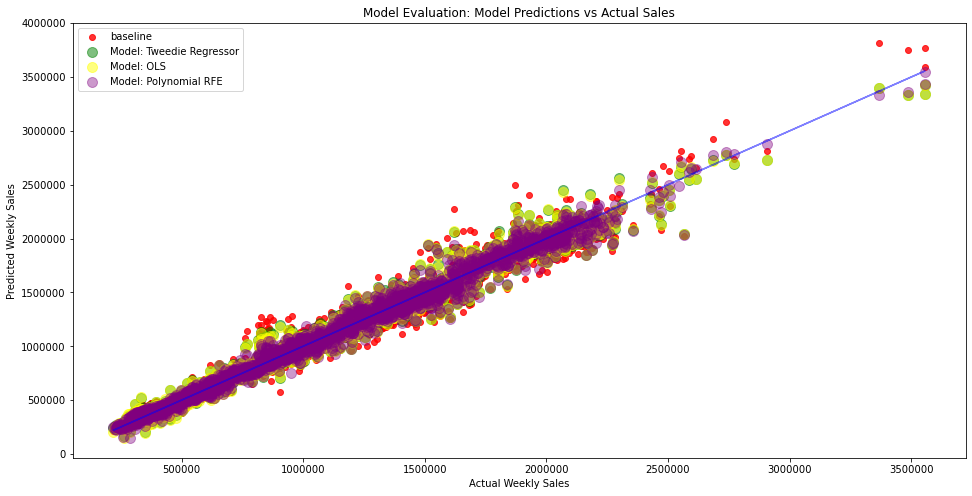

In [82]:
plt.figure(figsize=(16,8))
plt.scatter(y_train_df.actual, y_train_df.last_year_baseline, alpha=.8, color="red", label='baseline')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_train_df.actual, y_train_df.actual, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_train_df.actual, y_train_df.modelgml, 
            alpha=.5, color="green", s=100, label="Model: Tweedie Regressor")
plt.scatter(y_train_df.actual, y_train_df.modelOLS, 
            alpha=.5, color="yellow", s=100, label="Model: OLS")
plt.scatter(y_train_df.actual, y_train_df.pol3_RFE, 
            alpha=.4, color="purple", s=100, label="Model: Polynomial RFE")


plt.legend()
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Model Evaluation: Model Predictions vs Actual Sales")
plt.ticklabel_format(style = 'plain')
plt.show()

***
**Key Findings and Takeaways**

* Based on our R2 scores, our baseline was a fairly predictive methodology and left a small window for improvement  
    * 97.4% of the variance in our target could be explained by last year's sales data alone
    * red dots in the chart above show how tight last year's sales data lies to the actual sales data our model was attempting to predict
* Nevertheless, we were able to use the provided data, engineer a few features and successfully build a model that improved on the baseline and explains 98.7% of the target variance.  

***

## -  Polynomial Features

In [83]:
# Best model
pf = PolynomialFeatures(degree = 2)
pf.fit_transform(X_train_scaled[top_rfe_pol])
mod =LinearRegression( normalize=False, fit_intercept = False )
mod.fit(X_train_degree2, y_train_df['actual'])
X_train_top = X_train_scaled[top_rfe_pol]


**-Get Features Names**

In [84]:

#create a df to store the features 
feature_importances = pd.DataFrame(mod.coef_, 
                                   index = pf.get_feature_names(X_train_top.columns), 
                                   columns=['importance']).sort_values('importance', ascending=False)

#reset index
feature_importances = feature_importances.reset_index().rename( columns ={'index': 'features'} )

# Index should start at 1 so it can show the rank of each feature
feature_importances.index = feature_importances.index + 1

In [85]:
#create a new df, that have the top 5 positive and negative features

In [86]:
 df_top =pd.concat([feature_importances.head(5), feature_importances.tail(5)])

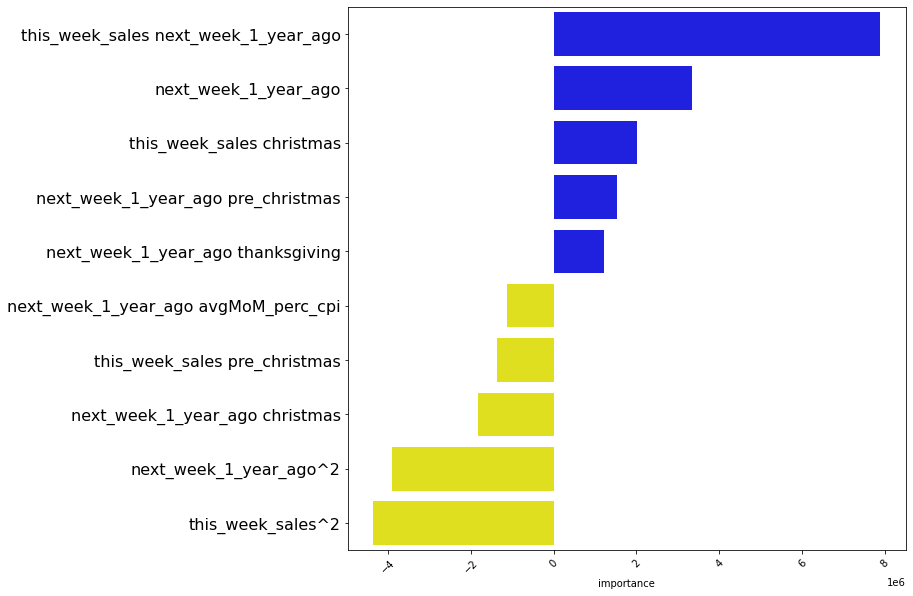

In [87]:
plt.figure(figsize=(10,10))
clrs = ['yellow' if (x < 0) else 'blue' for x in df_top.importance ]
sns.barplot(x='importance', y = 'features', data = df_top , palette=clrs)
plt.ylabel('')
plt.yticks(size=16)
plt.xticks(rotation=45)


plt.show()